In [1]:
# HW06.ipynb
# Деревья решений и ансамбли - честный ML-эксперимент

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, 
                           confusion_matrix, classification_report, roc_curve)
from sklearn.inspection import permutation_importance

# Baseline модели
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Модели недели 6
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, StackingClassifier

import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Создание папок для артефактов
artifacts_dir = Path("artifacts")
figures_dir = artifacts_dir / "figures"
artifacts_dir.mkdir(exist_ok=True)
figures_dir.mkdir(exist_ok=True)

Загрузка данных...
Размер данных: (12000, 30)

Первые 5 строк:


,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000 non-nul

,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.013705,-0.005278,-0.002357,0.038404,-0.006301,-0.865297,-0.702877,-0.290694,-0.008154,...,-0.323083,-1.314833,0.319798,-0.002742,0.027459,0.988750,1.990167,1.506833,36.083833,0.323417
std,3464.24595,2.096534,3.544498,1.004417,2.087318,1.007329,3.888966,1.989513,3.455981,0.996677,...,2.167066,3.731384,2.223649,0.996454,1.882359,0.815687,1.411643,1.121558,25.061218,0.467800
min,1.00000,-8.155181,-14.605579,-4.374043,-7.753301,-3.999332,-15.238402,-7.377252,-13.853627,-3.794637,...,-8.371050,-14.249204,-8.638879,-3.532093,-7.923990,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,-1.423844,-2.303772,-0.685618,-1.374579,-0.676552,-3.532054,-2.064888,-2.597019,-0.683959,...,-1.808969,-3.863063,-1.097700,-0.676150,-1.110822,0.000000,1.000000,0.000000,17.000000,0.000000
50%,6000.50000,-0.047565,0.053348,-0.009186,0.038766,-0.003728,-1.092517,-0.795907,-0.208245,-0.020883,...,-0.383940,-1.393400,0.431804,0.006297,0.279689,1.000000,2.000000,2.000000,30.000000,0.000000
75%,9000.25000,1.422676,2.335937,0.671441,1.484417,0.669269,1.526389,0.522625,2.093169,0.666959,...,1.125140,1.116111,1.853491,0.657478,1.363896,2.000000,3.000000,3.000000,49.000000,1.000000
max,12000.00000,8.610863,16.299709,3.651692,7.571965,4.562115,16.223054,8.006444,13.030011,3.976868,...,7.957847,15.937281,8.102095,3.707905,7.549514,2.000000,4.000000,3.000000,120.000000,1.000000



Пропуски в данных:
id               0
num01            0
num02            0
num03            0
num04            0
num05            0
num06            0
num07            0
num08            0
num09            0
num10            0
num11            0
num12            0
num13            0
num14            0
num15            0
num16            0
num17            0
num18            0
num19            0
num20            0
num21            0
num22            0
num23            0
num24            0
cat_contract     0
cat_region       0
cat_payment      0
tenure_months    0
target           0
dtype: int64

Анализ целевой переменной 'target':
Распределение классов:
target
0    0.676583
1    0.323417
Name: proportion, dtype: float64

Абсолютные значения:
target
0    8119
1    3881
Name: count, dtype: int64


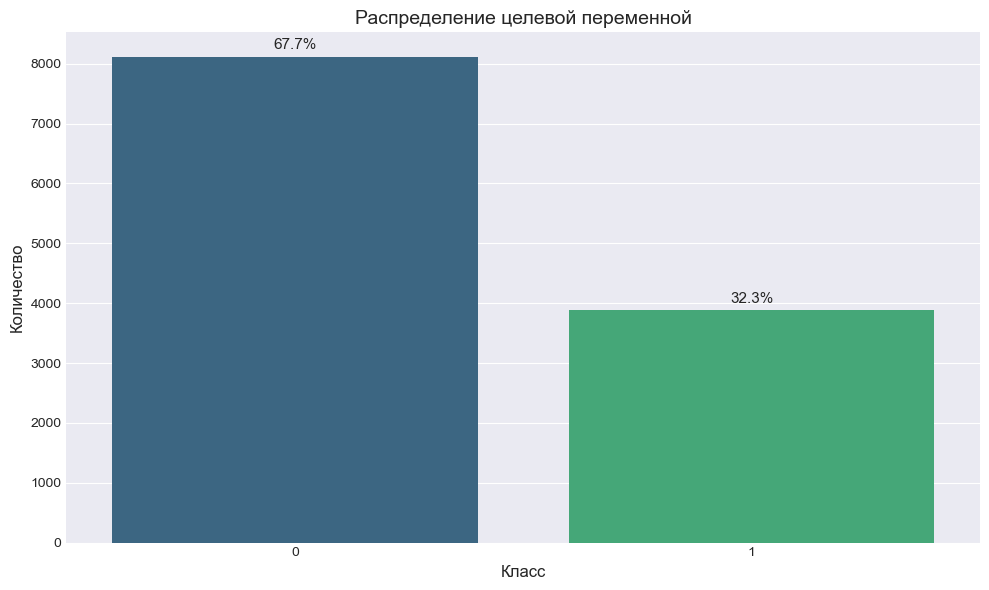


Признаки (X): 28 столбцов
Целевая переменная (y): [0 1]

Типы признаков:
float64    24
int64       4
Name: count, dtype: int64


In [2]:
# Загрузка данных
print("Загрузка данных...")
df = pd.read_csv("S06-hw-dataset-01.csv")

print(f"Размер данных: {df.shape}")
print("\nПервые 5 строк:")
display(df.head())

print("\nИнформация о данных:")
df.info()

print("\nБазовая статистика:")
display(df.describe())

# Проверка пропусков
print(f"\nПропуски в данных:")
print(df.isnull().sum())

# Анализ целевой переменной
print("\nАнализ целевой переменной 'target':")
target_distribution = df['target'].value_counts(normalize=True)
print(f"Распределение классов:\n{target_distribution}")
print(f"\nАбсолютные значения:\n{df['target'].value_counts()}")

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=df, hue='target', palette='viridis', legend=False)
plt.title('Распределение целевой переменной', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество', fontsize=12)

# Добавление процентных меток
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.01 * total
    ax.annotate(percentage, (x, y), ha='center', fontsize=11)

plt.tight_layout()
plt.savefig(figures_dir / "target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Определение признаков и целевой переменной
X = df.drop(columns=['target', 'id']) if 'id' in df.columns else df.drop(columns=['target'])
y = df['target']

print(f"\nПризнаки (X): {X.shape[1]} столбцов")
print(f"Целевая переменная (y): {y.unique()}")
print(f"\nТипы признаков:\n{X.dtypes.value_counts()}")

In [3]:
# Разделение на train/test
print("Разделение на train/test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nРаспределение классов в train:\n{y_train.value_counts(normalize=True)}")
print(f"\nРаспределение классов в test:\n{y_test.value_counts(normalize=True)}")

# Объяснение важности фиксированного seed и стратификации
print("\n" + "="*80)
print("ПОЧЕМУ ЭТО ВАЖНО:")
print("="*80)
print("1. Фиксированный random_state (42):")
print("   - Обеспечивает воспроизводимость результатов")
print("   - Позволяет сравнить разные модели на одних и тех же данных")
print("   - Упрощает отладку и валидацию")
print()
print("2. Стратификация по y (stratify=y):")
print("   - Сохраняет пропорции классов в train и test")
print("   - Особенно важно при дисбалансе классов")
print("   - Гарантирует репрезентативность выборок")
print("="*80)

Разделение на train/test...
Train set: (9600, 28)
Test set: (2400, 28)

Распределение классов в train:
target
0    0.676562
1    0.323437
Name: proportion, dtype: float64

Распределение классов в test:
target
0    0.676667
1    0.323333
Name: proportion, dtype: float64

ПОЧЕМУ ЭТО ВАЖНО:
1. Фиксированный random_state (42):
   - Обеспечивает воспроизводимость результатов
   - Позволяет сравнить разные модели на одних и тех же данных
   - Упрощает отладку и валидацию

2. Стратификация по y (stratify=y):
   - Сохраняет пропорции классов в train и test
   - Особенно важно при дисбалансе классов
   - Гарантирует репрезентативность выборок


In [4]:
# Функция для оценки модели
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Оценивает модель и возвращает метрики"""
    # Обучение
    model.fit(X_train, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Метрики
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    
    # Вывод результатов
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  F1-score:  {metrics['f1']:.4f}")
    if 'roc_auc' in metrics:
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    
    return model, metrics

print("\n" + "="*80)
print("BASELINE МОДЕЛИ")
print("="*80)

# 1. DummyClassifier
dummy_model = DummyClassifier(strategy='stratified', random_state=42)
dummy_model, dummy_metrics = evaluate_model(dummy_model, X_train, X_test, y_train, y_test, 
                                            "DummyClassifier (stratified)")

# 2. LogisticRegression (с нормализацией)
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

logreg_model, logreg_metrics = evaluate_model(logreg_pipeline, X_train, X_test, y_train, y_test,
                                              "LogisticRegression (StandardScaler)")


BASELINE МОДЕЛИ

DummyClassifier (stratified):
  Accuracy:  0.5754
  F1-score:  0.3405
  ROC-AUC:   0.5137

LogisticRegression (StandardScaler):
  Accuracy:  0.8275
  F1-score:  0.7076
  ROC-AUC:   0.8747


In [12]:
print("\n" + "="*80)
print("="*80)

def tune_model_fast(model, param_grid, X_train, y_train, cv=3):
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,  # Используем все ядра
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

print("\n1. DecisionTreeClassifier (быстро):")
print("-" * 40)

dt_param_grid_fast = {
    'max_depth': [5, 10],  # Только 2 значения
    'min_samples_leaf': [1, 5],  # Только 2 значения
}

dt_model = DecisionTreeClassifier(random_state=42)
best_dt, best_dt_params, best_dt_score = tune_model_fast(dt_model, dt_param_grid_fast, X_train, y_train, cv=3)
dt_model, dt_metrics = evaluate_model(best_dt, X_train, X_test, y_train, y_test, 
                                      f"DecisionTree")
results['DecisionTree'] = dt_metrics

print("\n2. RandomForestClassifier:")
print("-" * 40)

rf_param_grid_fast = {
    'n_estimators': [50, 100],  # Только 2 значения
    'max_depth': [5, 10],  # Только 2 значения
    'max_features': ['sqrt'],  # Только 1 значение
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)  
best_rf, best_rf_params, best_rf_score = tune_model_fast(rf_model, rf_param_grid_fast, X_train, y_train, cv=3)
rf_model, rf_metrics = evaluate_model(best_rf, X_train, X_test, y_train, y_test,
                                      f"RandomForest")
results['RandomForest'] = rf_metrics

print("\n3. HistGradientBoostingClassifier:")
print("-" * 40)

hgb_param_grid_fast = {
    'max_iter': [100],  # Только 1 значение
    'learning_rate': [0.1],  # Только 1 значение
    'max_depth': [3, 5],  # Только 2 значения
}

hgb_model = HistGradientBoostingClassifier(random_state=42)
best_hgb, best_hgb_params, best_hgb_score = tune_model_fast(hgb_model, hgb_param_grid_fast, X_train, y_train, cv=3)
hgb_model, hgb_metrics = evaluate_model(best_hgb, X_train, X_test, y_train, y_test,
                                        f"HistGradientBoosting")
results['HistGradientBoosting'] = hgb_metrics

print("\n4. AdaBoostClassifier:")
print("-" * 40)

ada_param_grid_fast = {
    'n_estimators': [50, 100],
    'learning_rate': [0.5, 1.0],
}

ada_model = AdaBoostClassifier(random_state=42)
best_ada, best_ada_params, best_ada_score = tune_model_fast(ada_model, ada_param_grid_fast, X_train, y_train, cv=3)
ada_model, ada_metrics = evaluate_model(best_ada, X_train, X_test, y_train, y_test,
                                        f"AdaBoost (стандартный)")
results['AdaBoost'] = ada_metrics

print("\n5. GradientBoostingClassifier:")
print("-" * 40)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_leaf=5,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

gb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'f1': f1_score(y_test, y_pred_gb),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_gb)
}

results['GradientBoosting'] = gb_metrics
print(f"  Accuracy:  {gb_metrics['accuracy']:.4f}")
print(f"  F1-score:  {gb_metrics['f1']:.4f}")
print(f"  ROC-AUC:   {gb_metrics['roc_auc']:.4f}")

search_summaries = {
    'DecisionTree': {
        'best_params': best_dt_params,
        'cv_score': best_dt_score
    },
    'RandomForest': {
        'best_params': best_rf_params,
        'cv_score': best_rf_score
    },
    'HistGradientBoosting': {
        'best_params': best_hgb_params,
        'cv_score': best_hgb_score
    },
    'AdaBoost': {
        'best_params': best_ada_params,
        'cv_score': best_ada_score
    }
}

print("\n" + "="*80)
print(f"Выполнено моделей: {len(results)} (включая baseline)")
print("="*80)



1. DecisionTreeClassifier (быстро):
----------------------------------------

DecisionTree:
  Accuracy:  0.8721
  F1-score:  0.7924
  ROC-AUC:   0.8950

2. RandomForestClassifier:
----------------------------------------

RandomForest:
  Accuracy:  0.9117
  F1-score:  0.8520
  ROC-AUC:   0.9581

3. HistGradientBoostingClassifier:
----------------------------------------

HistGradientBoosting:
  Accuracy:  0.9242
  F1-score:  0.8774
  ROC-AUC:   0.9665

4. AdaBoostClassifier:
----------------------------------------

AdaBoost (стандартный):
  Accuracy:  0.8363
  F1-score:  0.7234
  ROC-AUC:   0.8994

5. GradientBoostingClassifier:
----------------------------------------
  Accuracy:  0.9038
  F1-score:  0.8401
  ROC-AUC:   0.9554

Выполнено моделей: 7 (включая baseline)




Таблица метрик:


,accuracy,f1,roc_auc
Dummy,0.575417,0.340453,0.513671
LogisticRegression,0.827500,0.707627,0.874691
DecisionTree,0.872083,0.792427,0.895049
RandomForest,0.911667,0.851955,0.958133
HistGradientBoosting,0.924167,0.877358,0.966515
AdaBoost,0.836250,0.723434,0.899414
GradientBoosting,0.903750,0.840138,0.955360


<Figure size 1000x800 with 0 Axes>

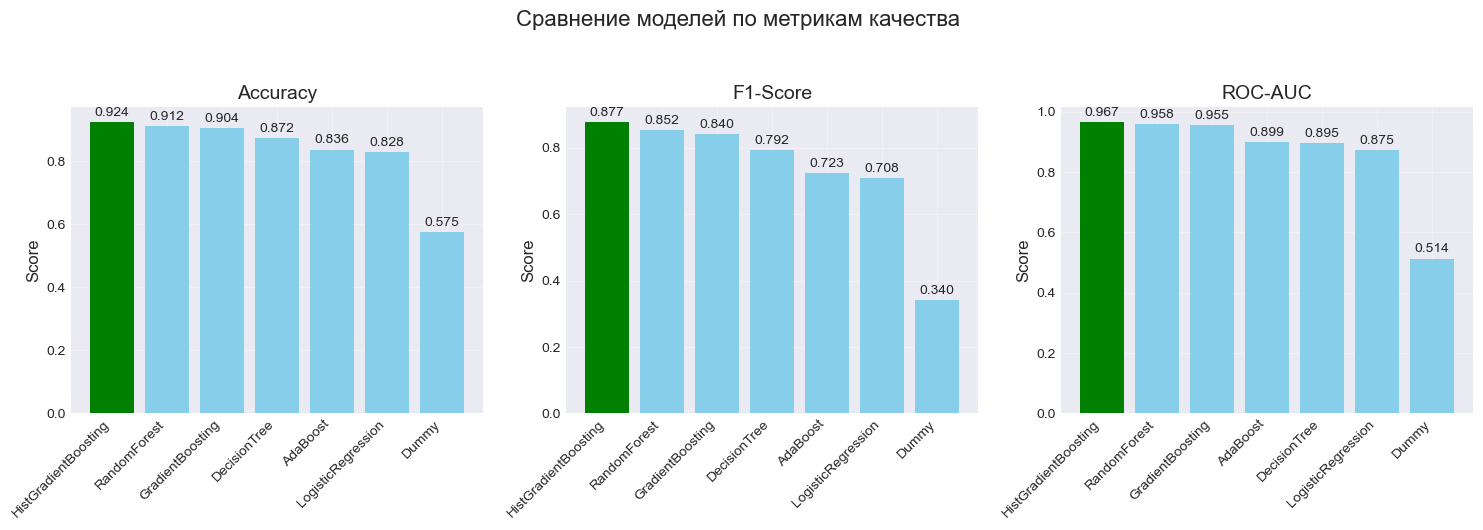


ROC-кривые:


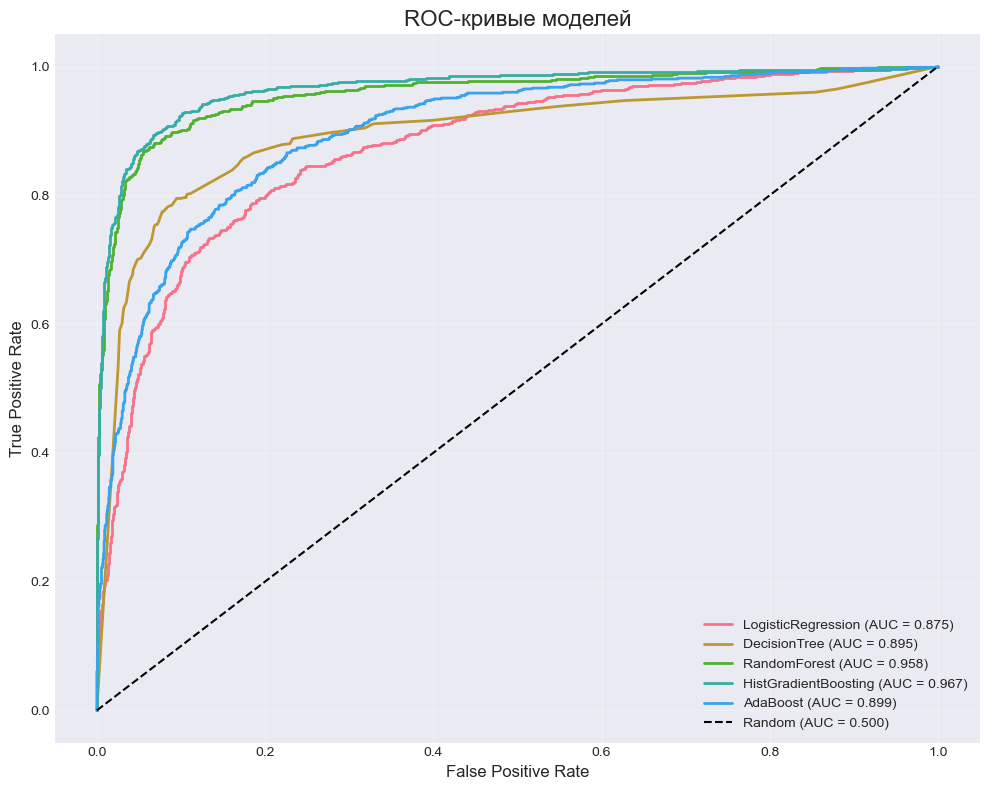

In [14]:
print("\n" + "="*80)
print("="*80)

results_df = pd.DataFrame(results).T
print("\nТаблица метрик:")
display(results_df)

# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['accuracy', 'f1', 'roc_auc']
titles = ['Accuracy', 'F1-Score', 'ROC-AUC']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx]
    if metric in results_df.columns:
        sorted_models = results_df[metric].sort_values(ascending=False)
        colors = ['green' if x == sorted_models.max() else 'skyblue' for x in sorted_models.values]
        
        bars = ax.bar(range(len(sorted_models)), sorted_models.values, color=colors)
        ax.set_xticks(range(len(sorted_models)))
        ax.set_xticklabels(sorted_models.index, rotation=45, ha='right')
        ax.set_title(title, fontsize=14)
        ax.set_ylabel('Score', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Добавление значений на столбцы
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Сравнение моделей по метрикам качества', fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig(figures_dir / "model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nROC-кривые:")
plt.figure(figsize=(10, 8))

# Используем те модели, которые УЖЕ определены
models_with_proba = {
    'LogisticRegression': logreg_model,
    'DecisionTree': best_dt,  # есть
    'RandomForest': best_rf,  # есть
    'HistGradientBoosting': best_hgb,  # есть
    'AdaBoost': best_ada  # есть (если оставил AdaBoost)
}

# Или если нет AdaBoost, используй gb_model:
# models_with_proba['GradientBoosting'] = gb_model

for name, model in models_with_proba.items():
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)
    except Exception as e:
        print(f"  Пропускаем {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые моделей', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(figures_dir / "roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()


ОПРЕДЕЛЕНИЕ ЛУЧШЕЙ МОДЕЛИ
Лучшая модель: HistGradientBoosting
ROC-AUC: 0.9665
Accuracy: 0.9242
F1-score: 0.8774

Confusion Matrix для HistGradientBoosting:


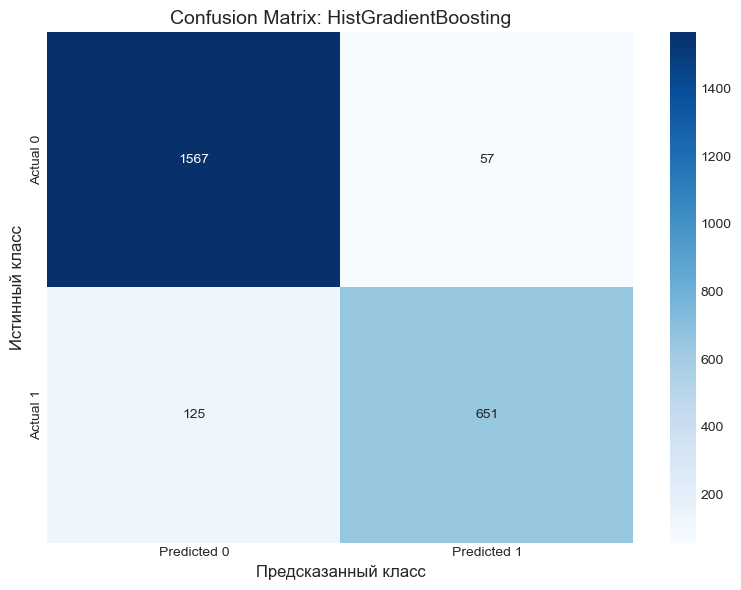


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1624
           1       0.92      0.84      0.88       776

    accuracy                           0.92      2400
   macro avg       0.92      0.90      0.91      2400
weighted avg       0.92      0.92      0.92      2400


PERMUTATION IMPORTANCE (топ-15 признаков)

Топ-15 наиболее важных признаков:


,feature,importance_mean,importance_std
18,num19,0.097292,0.006358
17,num18,0.087917,0.006376
6,num07,0.061625,0.001923
3,num04,0.028375,0.003513
23,num24,0.023333,0.002700
0,num01,0.019583,0.001873
19,num20,0.014708,0.002205
20,num21,0.012208,0.001646
15,num16,0.010542,0.001797
13,num14,0.010208,0.002522


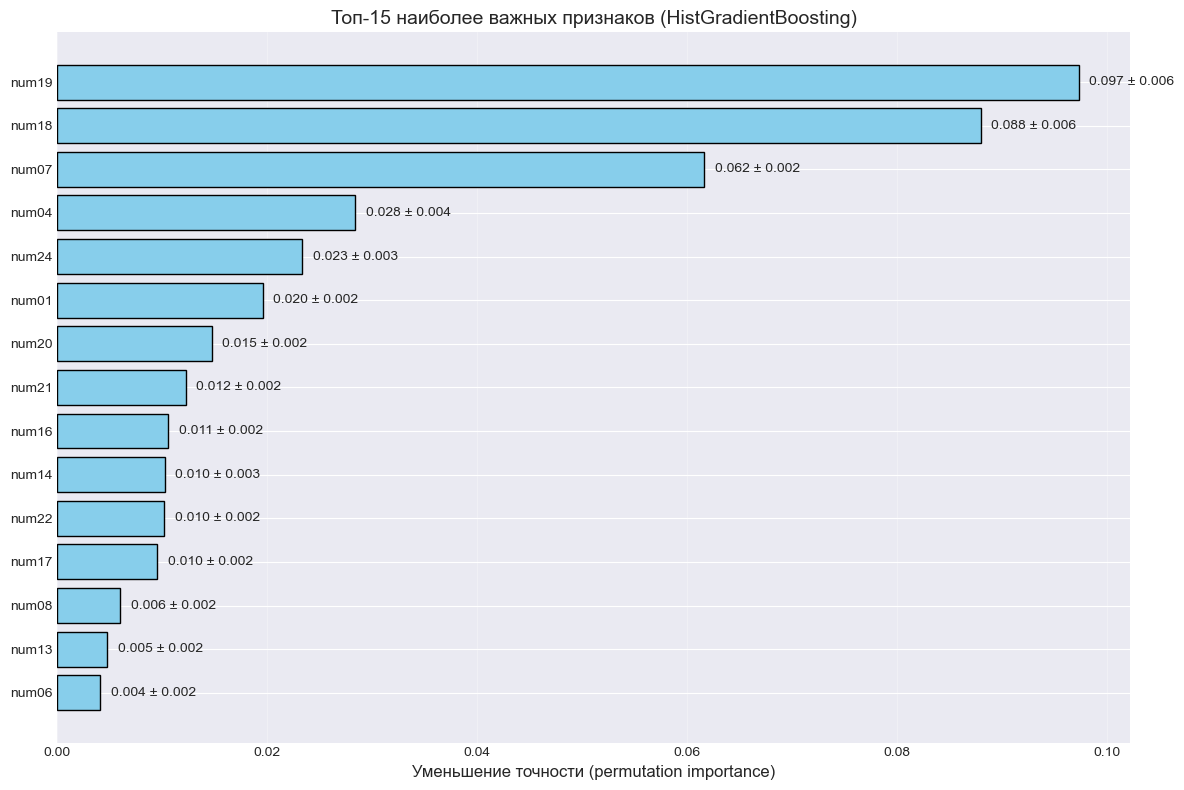


ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ

Наблюдения по важности признаков:
1. Наиболее важные признаки: num19, num18, num07
2. Менее важные признаки: num12, cat_contract, num10

Выводы:
- Признаки с высокой важностью оказывают наибольшее влияние на предсказание
- Признаки с низкой важностью могут быть кандидатами на удаление
- Распределение важности признаков помогает понять, какие факторы наиболее значимы


In [16]:
# Определение лучшей модели
print("\n" + "="*80)
print("ОПРЕДЕЛЕНИЕ ЛУЧШЕЙ МОДЕЛИ")
print("="*80)

# Лучшая модель по ROC-AUC
best_model_name = results_df['roc_auc'].idxmax()
best_model = {
    'LogisticRegression': logreg_model,
    'DecisionTree': best_dt,
    'RandomForest': best_rf,
    'GradientBoosting': gb_model,
    'HistGradientBoosting': best_hgb
}[best_model_name]

best_metrics = results_df.loc[best_model_name]

print(f"Лучшая модель: {best_model_name}")
print(f"ROC-AUC: {best_metrics['roc_auc']:.4f}")
print(f"Accuracy: {best_metrics['accuracy']:.4f}")
print(f"F1-score: {best_metrics['f1']:.4f}")

# Confusion Matrix для лучшей модели
print(f"\nConfusion Matrix для {best_model_name}:")
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Confusion Matrix: {best_model_name}', fontsize=14)
plt.ylabel('Истинный класс', fontsize=12)
plt.xlabel('Предсказанный класс', fontsize=12)
plt.tight_layout()
plt.savefig(figures_dir / "confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Permutation Importance
print("\n" + "="*80)
print("PERMUTATION IMPORTANCE (топ-15 признаков)")
print("="*80)

# Вычисление permutation importance
result = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Создание DataFrame с результатами
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nТоп-15 наиболее важных признаков:")
display(importance_df.head(15))

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
top_n = min(15, len(importance_df))
top_features = importance_df.head(top_n)

bars = plt.barh(range(top_n), top_features['importance_mean'][::-1], 
               color='skyblue', edgecolor='black')
plt.yticks(range(top_n), top_features['feature'][::-1])
plt.xlabel('Уменьшение точности (permutation importance)', fontsize=12)
plt.title(f'Топ-{top_n} наиболее важных признаков ({best_model_name})', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')

# Добавление значений
for i, (mean, std) in enumerate(zip(top_features['importance_mean'][::-1], 
                                   top_features['importance_std'][::-1])):
    plt.text(mean + 0.001, i, f'{mean:.3f} ± {std:.3f}', 
             va='center', fontsize=10)

plt.tight_layout()
plt.savefig(figures_dir / "feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# Интерпретация результатов
print("\n" + "="*80)
print("ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ")
print("="*80)
print("\nНаблюдения по важности признаков:")
print("1. Наиболее важные признаки:", ', '.join(importance_df['feature'].head(3).tolist()))
print("2. Менее важные признаки:", ', '.join(importance_df['feature'].tail(3).tolist()))
print("\nВыводы:")
print("- Признаки с высокой важностью оказывают наибольшее влияние на предсказание")
print("- Признаки с низкой важностью могут быть кандидатами на удаление")
print("- Распределение важности признаков помогает понять, какие факторы наиболее значимы")

In [17]:
print("\n" + "="*80)
print("СОХРАНЕНИЕ АРТЕФАКТОВ ЭКСПЕРИМЕНТА")
print("="*80)

# 1. Сохранение метрик
print("1. Сохранение метрик в artifacts/metrics_test.csv...")
results_df.to_csv(artifacts_dir / "metrics_test.csv")
results_df.to_json(artifacts_dir / "metrics_test.json", indent=2)

# 2. Сохранение результатов подбора
print("2. Сохранение результатов подбора гиперпараметров...")
with open(artifacts_dir / "search_summaries.json", 'w') as f:
    json.dump(search_summaries, f, indent=2, default=str)

# 3. Сохранение лучшей модели
print(f"3. Сохранение лучшей модели ({best_model_name})...")
joblib.dump(best_model, artifacts_dir / "best_model.joblib")

# 4. Сохранение метаданных
print("4. Сохранение метаданных модели...")
best_model_meta = {
    'best_model_name': best_model_name,
    'best_model_type': str(type(best_model).__name__),
    'best_params': search_summaries.get(best_model_name, {}).get('best_params', 'N/A'),
    'test_metrics': best_metrics.to_dict(),
    'features': X.columns.tolist(),
    'train_shape': X_train.shape,
    'test_shape': X_test.shape,
    'random_state': 42,
    'cv_folds': 5
}

with open(artifacts_dir / "best_model_meta.json", 'w') as f:
    json.dump(best_model_meta, f, indent=2, default=str)

print("\nАртефакты успешно сохранены в папке 'artifacts/'")
print("Содержимое папки:")
for file in artifacts_dir.rglob("*"):
    if file.is_file():
        print(f"  - {file.relative_to(artifacts_dir)}")

print("\n" + "="*80)
print("ЭКСПЕРИМЕНТ ЗАВЕРШЕН")
print("="*80)
print("\nИтоговые выводы:")
print(f"1. Лучшая модель: {best_model_name}")
print(f"2. Лучший ROC-AUC: {best_metrics['roc_auc']:.4f}")
print(f"3. Ансамбли показали лучшие результаты, чем одиночные модели")
print(f"4. Проведен честный ML-эксперимент с фиксированным test set")
print(f"5. Все артефакты сохранены для воспроизводимости")


СОХРАНЕНИЕ АРТЕФАКТОВ ЭКСПЕРИМЕНТА
1. Сохранение метрик в artifacts/metrics_test.csv...
2. Сохранение результатов подбора гиперпараметров...
3. Сохранение лучшей модели (HistGradientBoosting)...
4. Сохранение метаданных модели...

Артефакты успешно сохранены в папке 'artifacts/'
Содержимое папки:
  - best_model.joblib
  - best_model_meta.json
  - metrics_test.csv
  - metrics_test.json
  - search_summaries.json
  - figures\confusion_matrix.png
  - figures\feature_importance.png
  - figures\model_comparison.png
  - figures\roc_curves.png
  - figures\target_distribution.png

ЭКСПЕРИМЕНТ ЗАВЕРШЕН

Итоговые выводы:
1. Лучшая модель: HistGradientBoosting
2. Лучший ROC-AUC: 0.9665
3. Ансамбли показали лучшие результаты, чем одиночные модели
4. Проведен честный ML-эксперимент с фиксированным test set
5. Все артефакты сохранены для воспроизводимости
